# 机器学习纳米学位毕业项目--猫狗大战

## 1.导入相关包

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
import random


%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from zipfile import ZipFile

In [3]:
with ZipFile("train.zip", 'r') as f:
    f.extractall()

In [4]:
with ZipFile("test.zip", 'r') as f:
    f.extractall()

In [5]:
os.listdir()

['.jupyter',
 'src',
 '.ipython',
 'tutorials',
 '.conda',
 '.cmake',
 '.cache',
 '.zshrc',
 'train',
 'README',
 '.bashrc',
 'train.zip',
 '.config',
 '.sudo_as_admin_successful',
 'anaconda3',
 '.ssh',
 'examples',
 '.profile',
 'test',
 'test.zip',
 '.ipynb_checkpoints',
 'Nvidia_Cloud_EULA.pdf',
 '.dl_binaries',
 'sample_submission.csv',
 '.bash_logout',
 '.keras',
 '.local',
 'Untitled.ipynb']

### 从下面开始!

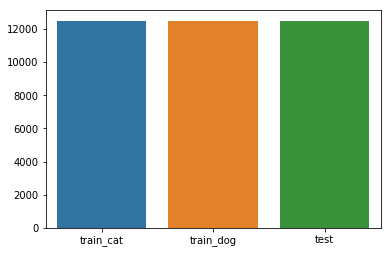

In [2]:
train_files = os.listdir('train/')
train_cat = [x for x in train_files if 'cat' in x]
train_dog = [x for x in train_files if 'dog' in x]

x = ['train_cat', 'train_dog', 'test']
y = [len(train_cat), len(train_dog), len(os.listdir('test/'))]

ax = sns.barplot(x, y)

In [3]:
count = f'猫：{len(train_cat)}, 狗：{len(train_dog)}, 测试集: {len(os.listdir("test/"))}'
count

'猫：12500, 狗：12500, 测试集: 12500'

##  拆分训练集和验证集

In [4]:
from sklearn.model_selection import train_test_split
# random_state保证每次分割都一样
img_train, img_valid = train_test_split(train_files, test_size=0.2,random_state = 0)
print(len(img_train), len(img_valid))

20000 5000


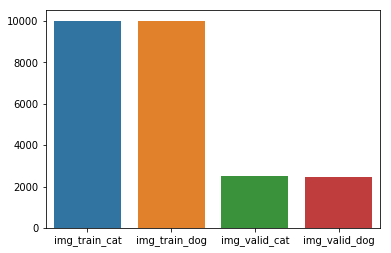

In [5]:
img_train_cat = [x for x in img_train if 'cat' in x]
img_train_dog = [x for x in img_train if 'dog' in x]
img_valid_cat = [x for x in img_valid if 'cat' in x]
img_valid_dog = [x for x in img_valid if 'dog' in x]
x = ['img_train_cat', 'img_train_dog', 'img_valid_cat', 'img_valid_dog']
y = [len(img_train_cat), len(img_train_dog), len(img_valid_cat), len(img_valid_dog)]

ax = sns.barplot(x=x, y=y)

### 创建符号连接

In [6]:
def remove_and_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    if dirname == 'img_test':
        os.mkdir(f'{dirname}/test')
    else:
        os.mkdir(f'{dirname}/cat')
        os.mkdir(f'{dirname}/dog')

In [7]:
remove_and_mkdir('img_train')
remove_and_mkdir('img_valid')
remove_and_mkdir('img_test')

In [8]:
os.listdir("img_train/")

['cat', 'dog']

In [9]:
img_test_files = os.listdir("test/")

In [10]:
for filename in img_train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in img_train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)
    
for filename in img_valid_cat:
    os.symlink('../../train/'+filename, 'img_valid/cat/'+filename)

for filename in img_valid_dog:
    os.symlink('../../train/'+filename, 'img_valid/dog/'+filename)   
    
for filename in img_test_files:
    os.symlink('../../test/'+filename, 'img_test/test/'+filename)

### 使用ImageDataGenerator 预处理
* 像素缩放到0和1
* 照片resize 299*299

In [11]:
os.listdir()

['.jupyter',
 'src',
 '.ipython',
 'tutorials',
 '.conda',
 '.cmake',
 'img_test',
 '.cache',
 '.zshrc',
 'train',
 'README',
 '.bash_history',
 '.bashrc',
 'train.zip',
 '.config',
 '.sudo_as_admin_successful',
 'img_valid',
 'anaconda3',
 '.ssh',
 'examples',
 '.profile',
 'test',
 '.nv',
 'Xception_best_binary_crossentropy_adadelta.h5',
 'test.zip',
 '.ipynb_checkpoints',
 'Nvidia_Cloud_EULA.pdf',
 'img_train',
 'Xception_best_binary_crossentropy_adadelta_tensor_log',
 '.dl_binaries',
 'sample_submission.csv',
 '.bash_logout',
 '.keras',
 '.local',
 'Untitled.ipynb']

In [12]:
from keras.preprocessing.image import ImageDataGenerator

target_image_size = (299, 299)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'img_train',
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        'img_valid', 
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### 打印一个batch的图片

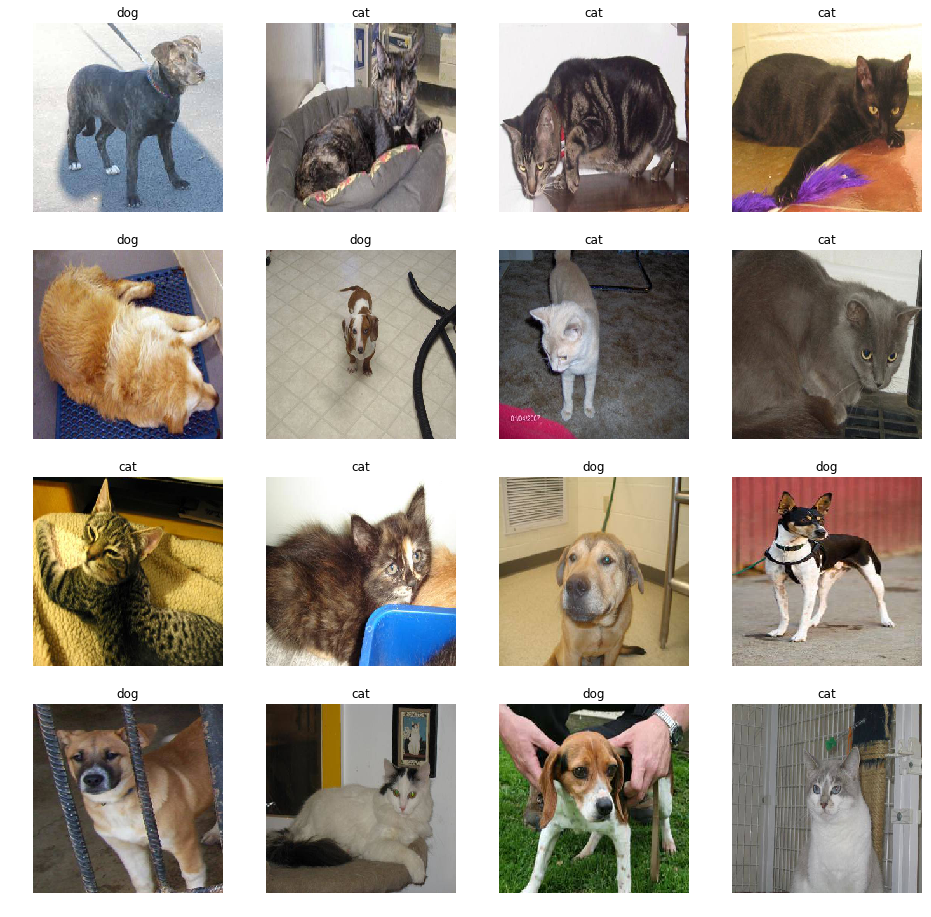

In [13]:
x, y = train_generator.next()
plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 4, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

In [14]:
## 构建模型
base_model = Xception(input_tensor=Input((299, 299, 3)), weights='imagenet', include_top=False)

In [18]:
## 冻结全连接所有层， 获取bottleneck特征
for layers in base_model.layers:
    layers.trainable = False

In [19]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [20]:
def train_func(loss_name,optimizer_name,model):
    model.compile(loss=loss_name, optimizer=optimizer_name, metrics=['accuracy'])
    best_model = ModelCheckpoint("Xception_best_{}_{}.h5".format(loss_name,optimizer_name), monitor='val_acc', verbose=0, save_best_only=True)
    tensor_log = "./Xception_best_{}_{}_tensor_log".format(loss_name,optimizer_name)
    return model,best_model,tensor_log

In [21]:
model,best_model,tensor_log = train_func("binary_crossentropy","adadelta",model)

In [ ]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=20000//16,
                    epochs=5, 
                    validation_data=validation_generator, 
                    validation_steps=5000//16,
                    callbacks=[best_model, TensorBoard(log_dir=tensor_log)])

Epoch 1/5
1250/1250 [==============================] - 220s 176ms/step - loss: 0.1216 - acc: 0.9627 - val_loss: 0.0985 - val_acc: 0.9696
Epoch 2/5
1250/1250 [==============================] - 151s 121ms/step - loss: 0.0723 - acc: 0.9756 - val_loss: 0.0708 - val_acc: 0.9798
Epoch 3/5
1250/1250 [==============================] - 150s 120ms/step - loss: 0.0647 - acc: 0.9777 - val_loss: 0.0735 - val_acc: 0.9778
Epoch 4/5
1213/1250 [============================>.] - ETA: 3s - loss: 0.0642 - acc: 0.9789

In [22]:
for layer in model.layers:
    layer.trainable = False
    
for layer in model.layers[97:]:
    layer.trainable = True
    
model.load_weights('Xception_best_binary_crossentropy_adadelta.h5')
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=20000//16,
                    epochs=5, 
                    validation_data=validation_generator, 
                    validation_steps=5000//16,
                    callbacks=[best_model, TensorBoard(log_dir=tensor_log)])

Epoch 1/5
1250/1250 [==============================] - 158s 127ms/step - loss: 0.0425 - acc: 0.9852 - val_loss: 0.0214 - val_acc: 0.9948
Epoch 2/5
1250/1250 [==============================] - 152s 121ms/step - loss: 0.0188 - acc: 0.9939 - val_loss: 0.0195 - val_acc: 0.9942
Epoch 3/5
1250/1250 [==============================] - 149s 119ms/step - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0423 - val_acc: 0.9914
Epoch 4/5
1250/1250 [==============================] - 153s 122ms/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0372 - val_acc: 0.9926
Epoch 5/5
1250/1250 [==============================] - 149s 119ms/step - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0360 - val_acc: 0.9920


In [24]:
#读取照片，并进行预处理
def get_image(image_num):
    img = cv2.imread('test/{}.jpg'.format(image_num))
    img = cv2.resize(img, target_image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img
test_num = 12500

In [25]:
# 生成kaggle提交文件
def generate_kaggle_file(pred_array,file_name):
    df = pd.read_csv("sample_submission.csv")
    df["label"] = pred_array
    print(file_name)
    df.to_csv('submission_{}.csv'.format(file_name), index=None)

In [26]:
import cv2
from tqdm import *

image_matrix = np.zeros((test_num,target_image_size[0], target_image_size[0], 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

100%|██████████| 12500/12500 [00:40<00:00, 312.43it/s]


In [27]:
opt_list = ["adadelta"]
for opt in opt_list:
    weights_name = 'Xception_best_binary_crossentropy_{}.h5'.format(opt)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred,opt)

12500/12500 [==============================] - 45s 4ms/step
adadelta
